In [4]:
import pandas as pd
import numpy as np
from future.utils.surrogateescape import encoded

from Models.DT import *
from utils.utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from Models.AutoEncoder import AutoEncoder, AE_trainDataset, AE_validDataset, AE_Dataset
from utils.utils import *
from tqdm import tqdm
from sklearn.metrics import f1_score

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
df = pd.read_csv("Data/[24-2 DS_Project2] Data.csv")

In [7]:
batch_size = 128
encoding_dim = 27
lr = 1e-4
l1_lambda = 1e-6

In [11]:
cat_features = ['Card', 'Gender', 'Card Brand', 'Card Type', 'Expires', 'Has Chip', 
                'Year PIN last Changed', 'Whether Security Chip is Used', 'Day']
num_features = ['Current Age', 'Retirement Age', 'Per Capita Income - Zipcode',
                'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Amount', 'Since Open Month']
discarded = ['User', 'Birth Year', 'Birth Month']

In [12]:
data_path = 'Data/[24-2 DS_Project2] Data.csv'

In [13]:
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), label_encoders = dt_process_data(
    data_path,
    cat_features,
    num_features,
    discarded
)

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [14]:
train_dataset = AE_Dataset(train_cat_X, train_num_X, train_y, device)
valid_dataset = AE_Dataset(valid_cat_X, valid_num_X, valid_y, device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = AutoEncoder(encoding_dim=encoding_dim, cat_features=cat_features, num_features=num_features).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()

In [19]:
checkpoint = torch.load('experiments/AutoEncoder/best_model.pth')
model.load_state_dict(checkpoint)

/tmp/ipykernel_6133/4157255290.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('experiments/AutoEncoder/best_model.pth')


<All keys matched successfully>

In [11]:
model.eval()

AutoEncoder(
  (cat_embeddings): ModuleList(
    (0-8): 9 x Embedding(100, 5)
  )
  (fc_cat): Linear(in_features=54, out_features=64, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=48, out_features=54, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [20]:
random_state=42 
max_depth=10
min_samples_leaf=5
class_weight={0: 1, 1: 10}

In [21]:
train_embeddings = model.get_embedding(
    torch.tensor(train_cat_X.values, dtype=torch.long).to(device),
    torch.tensor(train_num_X.values, dtype=torch.float).to(device),
)

In [22]:
valid_embeddings = model.get_embedding(
    torch.tensor(valid_cat_X.values, dtype=torch.long).to(device),
    torch.tensor(valid_num_X.values, dtype=torch.float).to(device),
)

/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


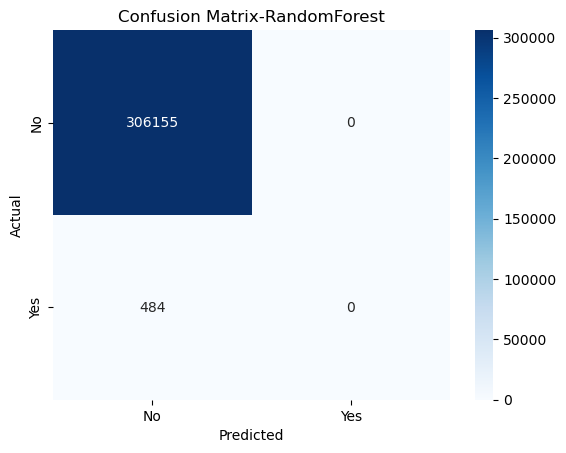

report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    306155
         1.0       0.00      0.00      0.00       484

    accuracy                           1.00    306639
   macro avg       0.50      0.50      0.50    306639
weighted avg       1.00      1.00      1.00    306639



/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hyun/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [23]:
randomforest(
    encoded_t=train_embeddings.cpu().detach().numpy(),
    encoded_v=valid_embeddings.cpu().detach().numpy(),
    train_y=train_y,
    valid_y=valid_y,
    le=label_encoders)